In [6]:
import torch

ValueError: module functions cannot set METH_CLASS or METH_STATIC

In [5]:
import numpy as np
data=np.load("../data/cats/fid_files/cats_64.npz")

In [23]:
data["m"].shape

(2048,)

In [4]:
import torch
x, y = torch.meshgrid(torch.linspace(-1, 1, 8, ),
                          torch.linspace(-1, 1, 8))
x


tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-0.7143, -0.7143, -0.7143, -0.7143, -0.7143, -0.7143, -0.7143, -0.7143],
        [-0.4286, -0.4286, -0.4286, -0.4286, -0.4286, -0.4286, -0.4286, -0.4286],
        [-0.1429, -0.1429, -0.1429, -0.1429, -0.1429, -0.1429, -0.1429, -0.1429],
        [ 0.1429,  0.1429,  0.1429,  0.1429,  0.1429,  0.1429,  0.1429,  0.1429],
        [ 0.4286,  0.4286,  0.4286,  0.4286,  0.4286,  0.4286,  0.4286,  0.4286],
        [ 0.7143,  0.7143,  0.7143,  0.7143,  0.7143,  0.7143,  0.7143,  0.7143],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000]])

In [5]:
y

tensor([[-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000],
        [-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000],
        [-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000],
        [-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000],
        [-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000],
        [-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000],
        [-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000],
        [-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000]])

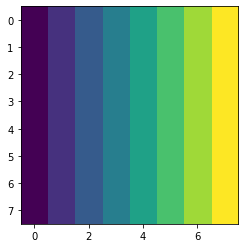

In [16]:
import matplotlib.pyplot as plt
plt.imshow(x.T)

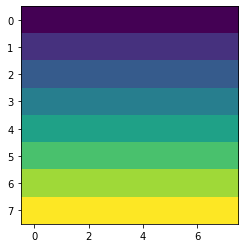

In [14]:
plt.imshow(y.T)

In [26]:
import math
import numpy as np
z=-torch.ones_like(x)/np.tan((2 * math.pi * 30 / 360)/2)

def normalize_vecs(vectors: torch.Tensor) -> torch.Tensor:
    """
    Normalize vector lengths.
    """
    return vectors / (torch.norm(vectors, dim=-1, keepdim=True))

normalize_vecs(torch.stack([x, y, z], -1))

tensor([[[-0.2506, -0.2506, -0.9351],
         [-0.2545, -0.1818, -0.9498],
         [-0.2572, -0.1102, -0.9600],
         [-0.2586, -0.0369, -0.9653],
         [-0.2586,  0.0369, -0.9653],
         [-0.2572,  0.1102, -0.9600],
         [-0.2545,  0.1818, -0.9498],
         [-0.2506,  0.2506, -0.9351]],

        [[-0.1818, -0.2545, -0.9498],
         [-0.1847, -0.1847, -0.9653],
         [-0.1868, -0.1121, -0.9760],
         [-0.1878, -0.0376, -0.9815],
         [-0.1878,  0.0376, -0.9815],
         [-0.1868,  0.1121, -0.9760],
         [-0.1847,  0.1847, -0.9653],
         [-0.1818,  0.2545, -0.9498]],

        [[-0.1102, -0.2572, -0.9600],
         [-0.1121, -0.1868, -0.9760],
         [-0.1134, -0.1134, -0.9871],
         [-0.1140, -0.0380, -0.9928],
         [-0.1140,  0.0380, -0.9928],
         [-0.1134,  0.1134, -0.9871],
         [-0.1121,  0.1868, -0.9760],
         [-0.1102,  0.2572, -0.9600]],

        [[-0.0369, -0.2586, -0.9653],
         [-0.0376, -0.1878, -0.9815],
      

In [25]:
torch.stack([x,y,z],-1)

tensor([[[-1.0000, -1.0000, -3.7321],
         [-1.0000, -0.7143, -3.7321],
         [-1.0000, -0.4286, -3.7321],
         [-1.0000, -0.1429, -3.7321],
         [-1.0000,  0.1429, -3.7321],
         [-1.0000,  0.4286, -3.7321],
         [-1.0000,  0.7143, -3.7321],
         [-1.0000,  1.0000, -3.7321]],

        [[-0.7143, -1.0000, -3.7321],
         [-0.7143, -0.7143, -3.7321],
         [-0.7143, -0.4286, -3.7321],
         [-0.7143, -0.1429, -3.7321],
         [-0.7143,  0.1429, -3.7321],
         [-0.7143,  0.4286, -3.7321],
         [-0.7143,  0.7143, -3.7321],
         [-0.7143,  1.0000, -3.7321]],

        [[-0.4286, -1.0000, -3.7321],
         [-0.4286, -0.7143, -3.7321],
         [-0.4286, -0.4286, -3.7321],
         [-0.4286, -0.1429, -3.7321],
         [-0.4286,  0.1429, -3.7321],
         [-0.4286,  0.4286, -3.7321],
         [-0.4286,  0.7143, -3.7321],
         [-0.4286,  1.0000, -3.7321]],

        [[-0.1429, -1.0000, -3.7321],
         [-0.1429, -0.7143, -3.7321],
      

In [39]:
x
valid=x.new_empty(x.shape + (4,)).normal_()
ind = valid.max(-1, keepdim=True)[1]
ind

tensor([[[2],
         [1],
         [3],
         [0],
         [3],
         [1],
         [3],
         [0]],

        [[1],
         [0],
         [2],
         [3],
         [1],
         [0],
         [1],
         [2]],

        [[2],
         [1],
         [2],
         [0],
         [0],
         [2],
         [0],
         [2]],

        [[3],
         [0],
         [3],
         [0],
         [0],
         [3],
         [0],
         [0]],

        [[1],
         [3],
         [2],
         [0],
         [3],
         [1],
         [0],
         [1]],

        [[1],
         [3],
         [3],
         [0],
         [2],
         [3],
         [2],
         [1]],

        [[2],
         [1],
         [2],
         [1],
         [3],
         [1],
         [0],
         [1]],

        [[0],
         [0],
         [3],
         [1],
         [2],
         [1],
         [3],
         [0]]])

In [40]:
valid

tensor([[[-0.2447, -0.1173,  0.1584, -0.1600],
         [ 0.1862,  1.9551,  0.1481, -0.4788],
         [-1.3724,  0.2085, -1.4820,  1.1622],
         [ 1.0736, -0.8740, -0.5200, -0.7871],
         [-2.2516,  1.1573, -0.5782,  1.2981],
         [-0.4302,  1.9370, -1.6892,  1.6644],
         [-0.7176,  0.0867,  0.4100,  1.3386],
         [ 0.2985, -0.0836, -0.9049, -0.5336]],

        [[ 1.7648,  1.8589, -1.1262, -1.5823],
         [-0.0770, -1.0479, -0.6213, -0.8038],
         [-0.1461,  0.2232,  0.3118, -1.4564],
         [-0.3161,  1.0731,  0.4276,  1.8604],
         [-2.0494,  0.1484, -0.7886, -1.7644],
         [ 1.7135, -3.4377,  0.1346,  1.5132],
         [ 0.5931,  1.2515, -0.3256, -0.1642],
         [-0.0119, -2.1389,  1.0927, -0.6142]],

        [[ 0.1950, -1.8419,  0.6646,  0.3407],
         [-0.6397,  2.1512, -1.2290, -1.7316],
         [ 0.4488, -0.0959,  0.6553,  0.4596],
         [ 0.0864, -0.0566, -1.9951, -0.6907],
         [ 1.7080,  0.4873, -0.6541, -2.2615],
         